In [1]:
import tensorflow as tf
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib


In [2]:
# SAMPLES = 32
# TIME = 6
# FEATURES = 40
# generator = tf.random.Generator.from_seed(1)
# data = generator.normal(shape=[40, 3])
# X = generator.normal(shape=[SAMPLES, TIME, FEATURES])
# y = generator.normal(shape=[SAMPLES, 2])

In [3]:
from decomposition import Filter
class IterativeFilterCallback(tf.keras.callbacks.Callback):
    def __init__(self, windower, model_class, iterations=2, iteration=0, threshold=0.2):
        # self.train_dataset = train_dataset
        # self.iteration = iteration
        # self.iterations = iterations
        self.model_class = model_class
        self.threshold = threshold
        self.windower = windower

        if isinstance(threshold, int):
            self.k = threshold
        

    def on_train_end(self, logs={}):
        # if self.iteration >= self.iterations:
        #     return
        model = self.model

        attention_weights = []
        for x, _ in self.windower.train:
            attention_weights.append(model.get_attention_weights(x))
        
        # print(attention_weights)
        attention_weights = tf.concat(attention_weights, axis=0)
        averaged_attention_weights = tf.math.reduce_mean(tf.math.reduce_mean(attention_weights, axis=0), axis=0)
        # print(averaged_attention_weights)
        
        ######## THIS IS TEMPORARY ########
        self.threshold = tf.reduce_mean(averaged_attention_weights)
        ######## THIS IS TEMPORARY ########

        try:
            self.indices = tf.math.top_k(averaged_attention_weights, self.k, sorted=False).indices
            # print(self.indices)

        except AttributeError:
            self.mask = averaged_attention_weights >= self.threshold
            self.indices = tf.where(self.mask)

        columns = self.windower.train_df.columns[tf.reshape(self.indices, (-1,))]
        # print(columns)
        columns = self.windower.label_columns + list(columns)
        columns = sorted(list(set(columns)))
        filter = Filter(columns)
        
        filtered_windower = self.windower.copy()
        filtered_windower.preprocess(filter)
        self.filtered_windower = filtered_windower


In [4]:

#filter_callback = IterativeFilterCallback(STL_X, y, Model, iterations=0)
#filter_callback.filtered_indices
#model.summary()


In [119]:

cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]

bas_directory = code_directory / "notebooks" / "Bas"
data_file = bas_directory / "df_filtered_maize_trade_oil_weather_futures.xlsx"
data_file


df = pd.read_excel(data_file, header=[0, 1], index_col=0)
df.head(5)

AVG_TAVG                                             \
PARTNER_Labels      Brazil      France     Germany Romania    Ukraine   
TIME_PERIOD                                                             
2005-01-01             NaN   50.081198   28.651592     NaN        NaN   
2005-02-01      266.743474   30.689158   -1.962406     NaN        NaN   
2005-03-01             NaN   76.202630   45.730051     NaN        NaN   
2005-04-01             NaN  108.081105  101.859649     NaN  90.622214   
2005-05-01             NaN  147.068032  134.667233     NaN        NaN   

               Corn Price Futures                                  ...  \
PARTNER_Labels             Brazil  France Germany Romania Ukraine  ...   
TIME_PERIOD                                                        ...   
2005-01-01                    NaN     NaN     NaN     NaN     NaN  ...   
2005-02-01                 222.75  222.75  222.75     NaN     NaN  ...   
2005-03-01                    NaN  221.00  221.00     NaN     NaN  ...   
2005-04-01                    NaN  213.50  213.50     NaN   213.5  ...   
2005-05-01                    NaN  230.75  230.75     NaN     NaN  ...   

               OIL_PRICE $/bbl                                           \
PARTNER_Labels          Brazil     France    Germany Romania    Ukraine   
TIME_PERIOD                                                               
2005-01-01                 NaN  42.972278  42.972278     NaN        NaN   
2005-02-01           44.818211  44.818211  44.818211     NaN        NaN   
2005-03-01                 NaN  50.942879  50.942879     NaN        NaN   
2005-04-01                 NaN  50.640476  50.640476     NaN  50.640476   
2005-05-01                 NaN  47.826573  47.826573     NaN        NaN   

                  price                                      
PARTNER_Labels   Brazil    France   Germany Romania Ukraine  
TIME_PERIOD                                                  
2005-01-01          NaN  0.122632  0.120429     NaN     NaN  
2005-02-01      0.16425  0.124028  0.109035     NaN     NaN  
2005-03-01          NaN  0.123698  0.118774     NaN     NaN  
2005-04-01          NaN  0.117439  0.109957     NaN     inf  
2005-05-01          NaN  0.123325  0.116828     NaN     NaN  

[5 rows x 40 columns]

In [120]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
df[label_columns] = np.log(df[label_columns])
df.head(5)

AVG_TAVG                                             \
PARTNER_Labels      Brazil      France     Germany Romania    Ukraine   
TIME_PERIOD                                                             
2005-01-01             NaN   50.081198   28.651592     NaN        NaN   
2005-02-01      266.743474   30.689158   -1.962406     NaN        NaN   
2005-03-01             NaN   76.202630   45.730051     NaN        NaN   
2005-04-01             NaN  108.081105  101.859649     NaN  90.622214   
2005-05-01             NaN  147.068032  134.667233     NaN        NaN   

               Corn Price Futures                                  ...  \
PARTNER_Labels             Brazil  France Germany Romania Ukraine  ...   
TIME_PERIOD                                                        ...   
2005-01-01                    NaN     NaN     NaN     NaN     NaN  ...   
2005-02-01                 222.75  222.75  222.75     NaN     NaN  ...   
2005-03-01                    NaN  221.00  221.00     NaN     NaN  ...   
2005-04-01                    NaN  213.50  213.50     NaN   213.5  ...   
2005-05-01                    NaN  230.75  230.75     NaN     NaN  ...   

               OIL_PRICE $/bbl                                           \
PARTNER_Labels          Brazil     France    Germany Romania    Ukraine   
TIME_PERIOD                                                               
2005-01-01                 NaN  42.972278  42.972278     NaN        NaN   
2005-02-01           44.818211  44.818211  44.818211     NaN        NaN   
2005-03-01                 NaN  50.942879  50.942879     NaN        NaN   
2005-04-01                 NaN  50.640476  50.640476     NaN  50.640476   
2005-05-01                 NaN  47.826573  47.826573     NaN        NaN   

                   price                                      
PARTNER_Labels    Brazil    France   Germany Romania Ukraine  
TIME_PERIOD                                                   
2005-01-01           NaN -2.098565 -2.116696     NaN     NaN  
2005-02-01     -1.806366 -2.087245 -2.216087     NaN     NaN  
2005-03-01           NaN -2.089911 -2.130536     NaN     NaN  
2005-04-01           NaN -2.141835 -2.207666     NaN     inf  
2005-05-01           NaN -2.092934 -2.147051     NaN     NaN  

[5 rows x 40 columns]

In [121]:
from decomposition import STLDecomposer

label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()


stl_preprocessor = STLDecomposer(labels=label_columns)

# data = dc(df)
# data.head(5)

In [122]:
from windower import WindowGenerator

width = 24
label_width = 10
shift = 4

w = WindowGenerator(input_width=width, label_width=label_width, shift=shift, data=df, 
                    split=[0, 0.6, 0.85, 1])
w.preprocess(stl_preprocessor)
w

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [18 19 20 21 22 23 24 25 26 27]
Label column name(s): None

In [123]:
w.train

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 55), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 55), dtype=tf.float32, name=None))>

In [124]:
df = w.train_df
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
# label_columns = [('price', 'France')]
w.set_label_columns(label_columns)

In [125]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 55)
Labels shape (batch, time, features): (32, 10, 5)


In [126]:
# for example_inputs, example_labels in w.train.take(1):
#     print(f'Inputs (batch, time, features): {example_inputs[1]}')
#     print(f'Labels (batch, time, features): {example_labels[1]}')

In [127]:
w.label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Romania'),
 ('price', 'Ukraine')]

In [128]:
from model import Attention
class FeedBack(tf.keras.Model):
    def __init__(self, pred_features, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.attention = Attention()
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        
        self.pred = tf.keras.layers.Dense(pred_features)

    def build(self, input_shape):
        num_features = input_shape[2] 
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        x, weights = self.attention(inputs)
        
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(x)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # # Insert the first prediction.
        # predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(0, self.out_steps):
                # Use the last prediction as input.
                x = prediction
                # Execute one lstm step.
                x, state = self.lstm_cell(x, states=state,
                                        training=training)
                # Convert the lstm output to a prediction.
                prediction = self.dense(x)
                pred = self.pred(x)
                # Add the prediction to the output.
                predictions.append(pred)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions
    
    def get_attention_weights(self, X):
        return self.attention(X)[1]

In [129]:
from model import Model
len(label_columns)
m = FeedBack(pred_features=5, units=32, out_steps=label_width)
m.compile(
    loss='mse', 
    metrics=['mae', 'mse', 'mape'],
    run_eagerly=False,
    )

filter_callback = IterativeFilterCallback(w, model_class=Model, iterations=1)
m.fit(w.train, batch_size=32, epochs=100, validation_data=w.val, callbacks=[filter_callback])

Epoch 1/100
4/4 [==============================] - 9s 489ms/step - loss: 1.7662 - mae: 1.1147 - mse: 1.7662 - mape: 37486788.0000 - val_loss: 2.1542 - val_mae: 1.4063 - val_mse: 2.1542 - val_mape: 12501852.0000
Epoch 2/100
4/4 [==============================] - 0s 69ms/step - loss: 0.9978 - mae: 0.8484 - mse: 0.9978 - mape: 91773536.0000 - val_loss: 1.2039 - val_mae: 0.9679 - val_mse: 1.2039 - val_mape: 34953768.0000
Epoch 3/100
4/4 [==============================] - 0s 61ms/step - loss: 0.5971 - mae: 0.6209 - mse: 0.5971 - mape: 163976464.0000 - val_loss: 0.8960 - val_mae: 0.7849 - val_mse: 0.8960 - val_mape: 45376252.0000
Epoch 4/100
4/4 [==============================] - 0s 59ms/step - loss: 0.5207 - mae: 0.5883 - mse: 0.5207 - mape: 200040512.0000 - val_loss: 0.7467 - val_mae: 0.6878 - val_mse: 0.7467 - val_mape: 39301652.0000
Epoch 5/100
4/4 [==============================] - 0s 61ms/step - loss: 0.4877 - mae: 0.5795 - mse: 0.4877 - mape: 208715968.0000 - val_loss: 0.6716 - val_ma

In [130]:
for example_inputs, example_labels in filter_callback.filtered_windower.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 9)
Labels shape (batch, time, features): (32, 10, 5)


In [131]:
print(filter_callback.filtered_windower.train_df.columns)
filter_callback.filtered_windower.train_df.head(4)

MultiIndex([('Corn Price Futures',  'Brazil'),
            (          'MIN_TMIN',  'Brazil'),
            (             'price',  'Brazil'),
            (             'price',  'France'),
            (             'price', 'Germany'),
            (             'price', 'Romania'),
            (             'price', 'Ukraine'),
            (    'price_seasonal', 'Romania'),
            (       'price_trend', 'Germany')],
           )


Corn Price Futures MIN_TMIN     price                              \
                        Brazil   Brazil    Brazil    France   Germany Romania   
TIME_PERIOD                                                                     
2005-01-01                0.00      0.0  0.000000 -2.098565 -2.116696     0.0   
2005-02-01              222.75    180.0 -1.806366 -2.087245 -2.216087     0.0   
2005-03-01                0.00      0.0  0.000000 -2.089911 -2.130536     0.0   
2005-04-01                0.00      0.0  0.000000 -2.141835 -2.207666     0.0   

                    price_seasonal price_trend  
            Ukraine        Romania     Germany  
TIME_PERIOD                                     
2005-01-01      0.0       0.005108   -2.189706  
2005-02-01      0.0       0.002036   -2.180665  
2005-03-01      0.0      -0.000050   -2.171568  
2005-04-01      0.0      -0.000717   -2.162437

In [132]:
filter_callback.threshold

<tf.Tensor: shape=(), dtype=float32, numpy=0.018181816>

In [133]:
w.label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Romania'),
 ('price', 'Ukraine')]

In [134]:
w = filter_callback.filtered_windower
w.train

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 5), dtype=tf.float32, name=None))>

In [135]:
w = filter_callback.filtered_windower
# w.column_indices
# m = Model(len(w.column_indices))
m = FeedBack(pred_features=5, units=32, out_steps=label_width)
m.compile(
    loss='mse', 
    metrics=['mae', 'mse', 'mape'],
    run_eagerly=False,
    )

filter_callback1 = IterativeFilterCallback(w, model_class=Model, iterations=1, threshold=2)
m.fit(w.train, batch_size=32, epochs=100, validation_data=w.val, callbacks=[filter_callback1])

Epoch 1/100
4/4 [==============================] - 9s 660ms/step - loss: 1.8836 - mae: 1.1327 - mse: 1.8836 - mape: 7959022.0000 - val_loss: 2.2628 - val_mae: 1.4412 - val_mse: 2.2628 - val_mape: 4489086.5000
Epoch 2/100
4/4 [==============================] - 0s 63ms/step - loss: 1.6345 - mae: 1.0813 - mse: 1.6345 - mape: 37433832.0000 - val_loss: 1.7012 - val_mae: 1.2349 - val_mse: 1.7012 - val_mape: 14665159.0000
Epoch 3/100
4/4 [==============================] - 0s 59ms/step - loss: 1.1136 - mae: 0.9414 - mse: 1.1136 - mape: 125669376.0000 - val_loss: 1.0631 - val_mae: 0.9112 - val_mse: 1.0631 - val_mape: 32227774.0000
Epoch 4/100
4/4 [==============================] - 0s 58ms/step - loss: 0.6831 - mae: 0.7472 - mse: 0.6831 - mape: 245328944.0000 - val_loss: 0.7947 - val_mae: 0.7525 - val_mse: 0.7947 - val_mape: 42604456.0000
Epoch 5/100
4/4 [==============================] - 0s 58ms/step - loss: 0.5303 - mae: 0.6340 - mse: 0.5303 - mape: 269261024.0000 - val_loss: 0.7510 - val_mae:

In [136]:
filter_callback1.filtered_windower.column_indices


{('price', 'Brazil'): 0,
 ('price', 'France'): 1,
 ('price', 'Germany'): 2,
 ('price', 'Romania'): 3,
 ('price', 'Ukraine'): 4,
 ('price_seasonal', 'Romania'): 5}

In [137]:
# Set NumPy print options to avoid scientific notation
np.set_printoptions(precision=4, suppress=True)

for example_inputs, example_labels in w.test.take(5):
    pred = tf.squeeze(m.predict(example_inputs)[:,:])
    unnormed_pred = (tf.squeeze(pred * w.train_std[label_columns].values)+w.train_mean[label_columns].values)
    # print(f'predictions: {pred}')
    lab = tf.squeeze(example_labels[:, :])
    unnormed_lab = ((lab * w.train_std[label_columns].values)+w.train_mean[label_columns].values).numpy()
    # print(f'labels: {lab.numpy()}')
    print(np.exp(tf.transpose(tf.stack([pred, lab]))))
    # attention_weights = m.get_attention_weights(example_inputs)
    # print(tf.squeeze(attention_weights))
    # print(f'normed labels: {example_labels[:,:,:].numpy()}')

m.evaluate(w.test)

1/1 [==============================] - 1s 1s/step
[[[[0.4345 0.2145]
   [0.4346 0.431 ]
   [0.4317 0.2488]
   [0.4198 0.7833]
   [0.4227 0.1608]
   [0.4266 1.9   ]]

  [[0.4352 0.1608]
   [0.4389 1.    ]
   [0.4377 0.431 ]
   [0.4315 1.9   ]
   [0.4316 0.7833]
   [0.4354 0.2488]]

  [[0.4385 0.7833]
   [0.4443 0.2561]
   [0.4442 1.    ]
   [0.4415 0.2488]
   [0.4408 1.9   ]
   [0.4435 0.431 ]]

  [[0.4443 1.9   ]
   [0.4513 0.4455]
   [0.4518 0.2561]
   [0.451  0.431 ]
   [0.45   0.2488]
   [0.452  1.    ]]

  [[0.4507 0.2488]
   [0.4582 0.4409]
   [0.459  0.4455]
   [0.4594 1.    ]
   [0.4582 0.431 ]
   [0.4598 0.2561]]

  [[0.4568 0.431 ]
   [0.4643 0.4   ]
   [0.4652 0.4409]
   [0.4663 0.2561]
   [0.4649 1.    ]
   [0.4663 0.4455]]

  [[0.4622 1.    ]
   [0.4695 0.3518]
   [0.4705 0.4   ]
   [0.4718 0.4455]
   [0.4704 0.2561]
   [0.4717 0.4409]]

  [[0.4668 0.2561]
   [0.4738 0.2118]
   [0.4747 0.3518]
   [0.4762 0.4409]
   [0.4748 0.4455]
   [0.476  0.4   ]]

  [[0.4707 0.4455]
   

[0.36613622307777405, 0.504685640335083, 0.36613622307777405, 15815100.0]

In [138]:
label_columns[1]
w.column_indices

{('Corn Price Futures', 'Brazil'): 0,
 ('MIN_TMIN', 'Brazil'): 1,
 ('price', 'Brazil'): 2,
 ('price', 'France'): 3,
 ('price', 'Germany'): 4,
 ('price', 'Romania'): 5,
 ('price', 'Ukraine'): 6,
 ('price_seasonal', 'Romania'): 7,
 ('price_trend', 'Germany'): 8}

1/1 [==============================] - 0s 142ms/step - loss: 0.6568 - mae: 0.5908 - mse: 0.6568 - mape: 58445696.0000
2
(32, 10, 5)
2
(32, 10, 5)
2
(32, 10, 5)
2
(32, 10, 5)
2
(32, 10, 5)
2
(32, 10, 5)


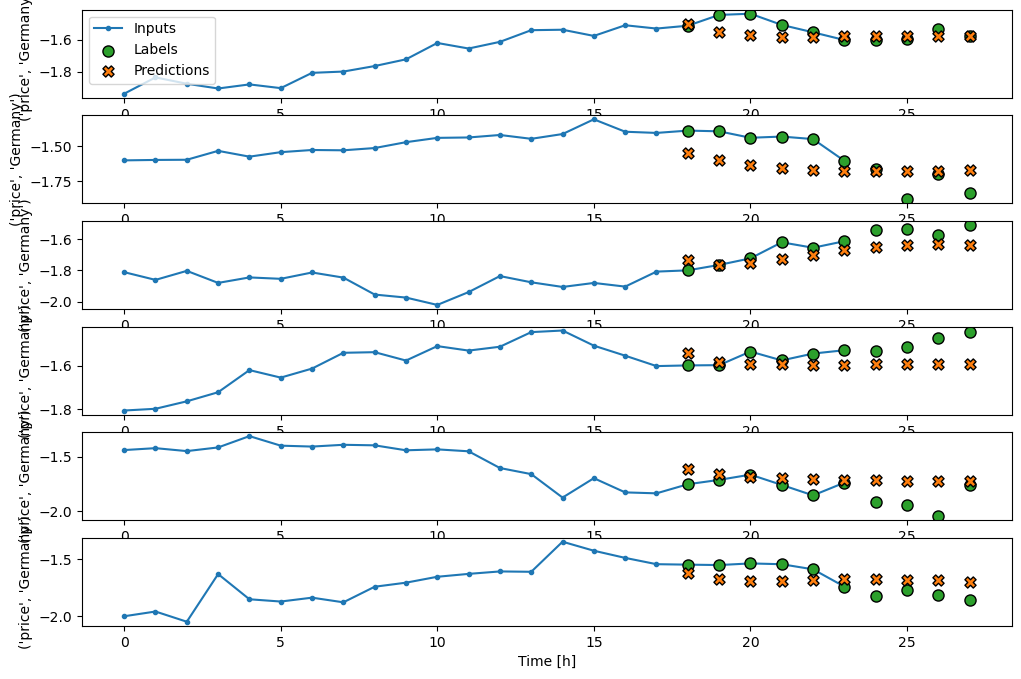

In [139]:
val_performance = {}
performance = {}

val_performance['1'] = m.evaluate(w.val)
# performance['1'] = m.evaluate(w.test)
w.plot(m, plot_col=label_columns[2], max_subplots=6)

In [57]:
for x, y in w.train:
    print(x.shape)

(23, 4, 12)


In [ ]:
performance['1']

[]

In [56]:
for example_inputs, example_labels in w.test.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs}')
    print(f'Labels shape (batch, time, features): {example_labels}')

Inputs shape (batch, time, features): [[[    59.316   21384.2     18030.27      112.3967     -1.3624
       -1.3542     -1.1722     -0.6162     -1.2825     -0.4808
        0.3651     -1.2088]
  [    84.9965      3.3     47985.68      103.4133     -0.8087
       -1.2707     -1.0467     -1.0479     -1.0235      0.0949
       -0.0925     -1.1827]
  [   151.0157      2.2     66821.08      110.0967     -0.8189
       -1.2033      0.1123     -1.1289     -0.9932      0.1065
       -0.1994     -1.1566]
  [   188.738       0.4     42230.62      116.8        -0.9163
       -1.2816     -0.5994     -1.1085     -0.9588      0.0311
       -0.2048     -1.1305]]

 [[   188.738       0.4     42230.62      116.8        -0.9163
       -1.2816     -0.5994     -1.1085     -0.9588      0.0311
       -0.2048     -1.1305]
  [   198.7234 129581.8     14759.27      105.0833     -1.0448
       -1.0184     -0.9578     -0.475      -1.0237     -0.0755
        0.4029     -1.1044]
  [   208.8009 345766.2     12726.04

In [29]:
w.test_df

AVG_TAVG OBS_VALUE_VALUE_1000EURO               price  \
                Ukraine                   Brazil   Germany    Brazil   
TIME_PERIOD                                                            
2021-12-01     3.514363                     1.07  22997.27 -1.390956   
2022-01-01    -8.409434                     1.25  10919.13 -0.841567   
2022-02-01    20.041667                     0.00   7340.10  0.000000   
2022-03-01    21.179429                  5475.43  18030.27 -1.362382   
2022-04-01    88.648470                     1.47  47985.68 -0.808660   
2022-05-01   147.099420                     0.97  66821.08 -0.818917   
2022-06-01   209.451222                     0.16  42230.62 -0.916291   
2022-07-01   212.861598                 45581.03  14759.27 -1.044821   
2022-08-01   224.523306                 73216.75  12726.04 -1.552339   
2022-09-01   136.176826                 46307.54   5539.75 -1.215594   
2022-10-01   113.858268                 12615.08  11407.63 -1.157448   

                                                    price_trend  
               France   Germany   Romania   Ukraine     Romania  
TIME_PERIOD                                                      
2021-12-01  -1.393474 -1.425739 -1.392093 -1.319505   -1.058904  
2022-01-01  -1.357537 -1.287509 -1.130485 -1.396603   -1.033038  
2022-02-01  -1.372557 -1.248083 -1.127225 -1.304564   -1.007173  
2022-03-01  -1.354198 -1.172227 -0.616186 -1.282459   -0.981307  
2022-04-01  -1.270711 -1.046658 -1.047911 -1.023543   -0.955441  
2022-05-01  -1.203302  0.112323 -1.128937 -0.993241   -0.929575  
2022-06-01  -1.281578 -0.599407 -1.108470 -0.958786   -0.903710  
2022-07-01  -1.018363 -0.957844 -0.474965 -1.023654   -0.877844  
2022-08-01  -1.238597 -1.076351 -0.615754 -1.028004   -0.851978  
2022-09-01  -0.831877 -1.861856 -1.095866 -1.159557   -0.826113  
2022-10-01  -0.817254 -1.121280 -0.616041 -1.161479   -0.800247